# KdV equation

In [1]:
import sys
import os
sys.path.append("./src")

In [2]:
import jax
import jax.numpy as jnp
import optax
from Data import *
from Plot import *
from NeuralNetwork import *
from InitialFit import *
from Solver import *
import time

### Setup

In [3]:
# Exact solution

def exactKdVTwoSol(x, t):
    '''
    Function taken from https://github.com/pehersto/ng/solvers/exactKdV.py
    Args:
        x: jnp.array, points in space
        t: jnp.array (or float), points in time
    '''

    k = jnp.asarray([1., jnp.sqrt(5.)])
    eta = jnp.asarray([0., 10.73])
    t = jnp.asarray(t) # in case t is a float

    etaMat1 = k[0] * x.reshape((-1, 1)) - k[0] ** 3 * t.reshape((1, -1)) + eta[0]
    etaMat2 = k[1] * x.reshape((-1, 1)) - k[1] ** 3 * t.reshape((1, -1)) + eta[1]
    c = ((k[0] - k[1]) / (k[0] + k[1]) )** 2

    f = 1. + jnp.exp(etaMat1) + jnp.exp(etaMat2) + jnp.multiply(jnp.exp(etaMat1), jnp.exp(etaMat2) * c)
    df = k[0] * jnp.exp(etaMat1) + k[1] * jnp.exp(etaMat2) + c * (k[0] + k[1]) * jnp.multiply(jnp.exp(etaMat1), jnp.exp(etaMat2))
    ddf = k[0] ** 2 * jnp.exp(etaMat1) + k[1] ** 2 * jnp.exp(etaMat2) + c * (k[0] + k[1]) ** 2 * jnp.multiply(jnp.exp(etaMat1), jnp.exp(etaMat2))

    y = 2 * jnp.divide(jnp.multiply(f, ddf) - df ** 2, f ** 2)

    y = jnp.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0) # avoid numerical errors far outside of [-1, 2]
    
    return y

In [4]:
# Problem and training data

problem_data = ProblemData(name='kdv', # problem name
                           d=1, # input dimension
                           domain=(-20, 40), # 1D: (lower, upper)
                           T=4, # final time
                           initial_fn=lambda x: exactKdVTwoSol(x, 0), # initial condition
                           exact_sol=exactKdVTwoSol, # exact solution
                           N=2048, # number of spatial points
                           dt=1.0, # time step (not needed here, we use an adaptive step with RK45)
                          )

training_data = TrainingData(m=10, # number of neurons per layer
                             l=1, # number of layers
                             batch_size=5000, # batch size
                             epochs=10000, # number of epochs
                             gamma=0.1, # learning rate
                             seed=0, # seed for reproducibility
                             scheduler=optax.exponential_decay(init_value=0.1, transition_steps=1000, decay_rate=0.9) # learning rate scheduler
                             # scheduler=optax.linear_schedule(init_value=0.1, end_value=0.001, 
                             #                                 transition_steps=1000, transition_begin=1000) # learning rate scheduler
                             # scheduler=optax.piecewise_constant_schedule(init_value=0.1, boundaries_and_scales={1000: 0.1}) # learning rate scheduler
                            )

In [5]:
# Neural network

net = ShallowNetKdV(training_data.m, problem_data.domain[1] - problem_data.domain[0])
print(net)

ShallowNetKdV(
    # attributes
    m = 10
    L = 60
)


### Initial fit

In [6]:
# Initial fit

initial_fit = False # True to train a NN to fit the initial condition, False otherwise

if initial_fit:
    theta = init_neural_galerkin(net, problem_data, training_data) # train a NN to fit the initial condition
    jnp.save('./data/theta_init_' + problem_data.name + '_' + str(training_data.seed) + '.npy', theta)
else:
    theta = jnp.load('./data/theta_init_' + problem_data.name + '_' + str(training_data.seed) + '.npy', allow_pickle=True).item()
    x_plot = jnp.linspace(problem_data.domain[0], problem_data.domain[1], problem_data.N)
    relative_error = jnp.linalg.norm(net.apply(theta, x_plot.reshape(-1, 1)) - exactKdVTwoSol(x_plot, 0)) / jnp.linalg.norm(exactKdVTwoSol(x_plot, 0))
    print("Relative error of the initial fit:", relative_error)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Relative error of the initial fit: 0.0059745763


### Time evolution

In [7]:
# Source term for the KdV equation

def rhs_kdv(theta_flat, x, t, u_fn):
    U = jax.vmap(u_fn, (None, 0)) # jax.vmap(fun, in_axes)
    U_dx = jax.vmap(gradsqz(u_fn, 1), (None, 0))
    U_dddx = jax.vmap(gradsqz(gradsqz(gradsqz(u_fn, 1), 1), 1), (None, 0))
    u = U(theta_flat, x)
    u_x = U_dx(theta_flat, x)
    u_xxx = U_dddx(theta_flat, x)
    return - u_xxx - 6 * u * u_x

In [ ]:
solution, timesteps, diagnostic = neural_galerkin(theta=theta, # initial parameters
                                                  net=net, # neural network
                                                  problem_data=problem_data, # problem data
                                                  n=1000, # sample points
                                                  rhs=rhs_kdv, # problem RHS
                                                  x_init=None,
                                                  sampler='uniform',
                                                  scheme='rk45',
                                                  diagnostic_on=True, # save conditioning number and singular values of the mass matrix
                                                 )

In [ ]:
plot_solution(solution, timesteps, problem_data)

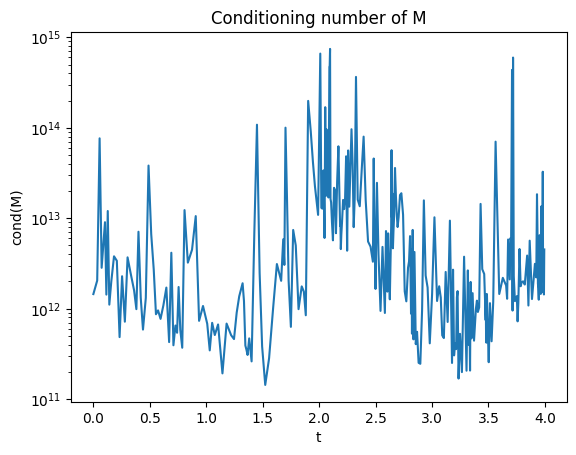

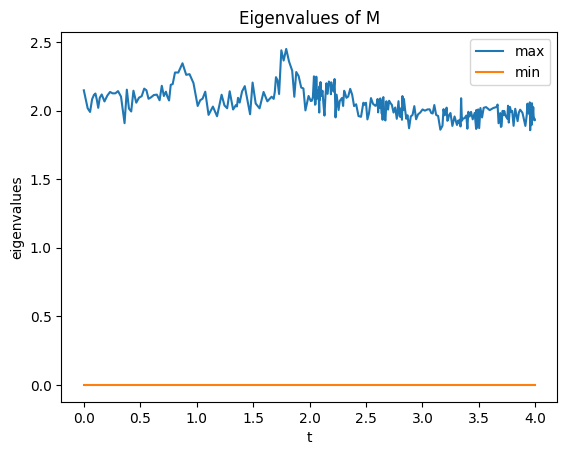

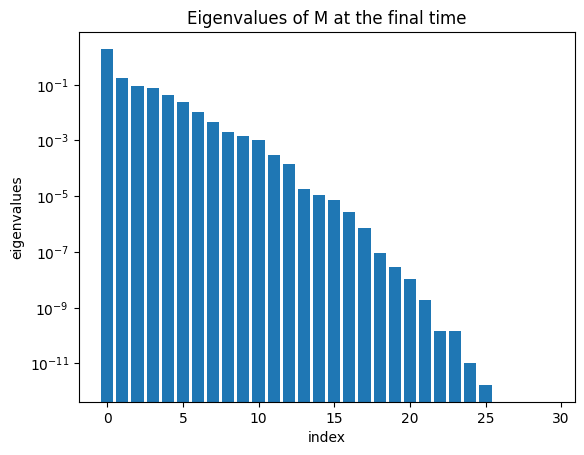

In [10]:
diagnostic.plot(timesteps)

### Conditioning number w.r.t. number of samples

In [ ]:
samples_list = [1000, 2000, 4000, 8000, 16000, 24000, 32000, 48000, 64000, 72000]
time_list = []
cond_list = []
# max_eig_list = []
# min_eig_list = []

for samples in samples_list:

    print(f'Running model with {samples} samples...')
    
    time_sum = 0.0
    cond_list_int = []
    cond_nan = 0
    
    for i in range(5): # repeat each run 5 times
        start = time.time()
        solution, timesteps, diagnostic = neural_galerkin(theta=theta, # initial parameters
                                                          net=net, # neural network
                                                          problem_data=problem_data, # problem data
                                                          n=samples, # sample points
                                                          rhs=rhs_kdv, # problem RHS
                                                          x_init=None,
                                                          sampler='uniform',
                                                          scheme='rk45',
                                                          diagnostic_on=True, # save conditioning number and singular values of the mass matrix
                                                          plot_on=False,
                                                          seed=1000*i
                                                         )
        end = time.time()
        time_sum += end - start
        cond = diagnostic.averaged()[0]
        if jnp.isnan(cond):
            cond_nan += 1
        else:
            cond_list_int.append(cond)
    
    print(f'{cond_nan} NaN condition numbers detected.')
    print(cond_list_int)
    time_list.append(time_sum / 5.0)
    cond_list.append(cond_list_int)
    # avg_cond, avg_max_eig, avg_min_eig = diagnostic.averaged()
    # cond_list.append(avg_cond)
    # max_eig_list.append(avg_max_eig)
    # min_eig_list.append(avg_min_eig)

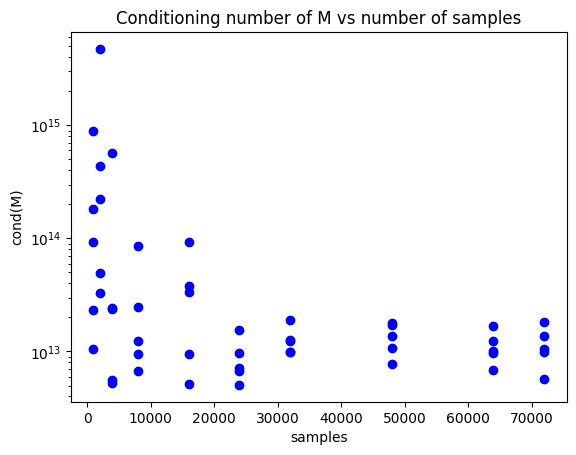

In [5]:
samples_list = [1000, 2000, 4000, 8000, 16000, 24000, 32000, 48000, 64000, 72000] # 96000]
cond_list = [[2.333777e+13, 8.9458626e+14, 9.2429005e+13, 1.823527e+14, 1.0469402e+13],
             [2.2445073e+14, 4.746919e+15, 3.2812506e+13, 4.3798114e+14, 4.9339783e+13],
             [5.724211e+14, 5.310578e+12, 5.621322e+12, 2.4177927e+13, 2.3636147e+13],
             [6.739443e+12, 2.465955e+13, 1.2345669e+13, 9.423549e+12, 8.546667e+13],
             [5.196893e+12, 3.8218762e+13, 9.44217e+12, 3.34404e+13, 9.235051e+13],
             [5.0613883e+12, 1.5357504e+13, 6.6658826e+12, 7.1560426e+12, 9.692988e+12],
             [1.260837e+13, 1.879964e+13, 9.914307e+12, 1.2441332e+13, 9.988002e+12],
             [1.7309767e+13, 1.3768994e+13, 1.0788469e+13, 1.7708448e+13, 7.789299e+12],
             [1.2419632e+13, 1.6906957e+13, 6.8052173e+12, 1.000318e+13, 9.7296e+12],
             [1.8344074e+13, 1.3634701e+13, 1.0622008e+13, 5.736802e+12, 9.925645e+12],
             # [3.7111563e+13, 3.2279974e+13, 9.211223e+12, 8.216774e+13, 6.7599613e+12]
            ]

cond_avg = [jnp.mean(jnp.array(cond)) for cond in cond_list]
for idx, samples in enumerate(samples_list):
    for c in range(len(cond_list[idx])):
        plt.scatter(samples, cond_list[idx][c], c='b')
# plt.plot(samples_list, cond_avg, 'r-*', label='avg')
# plt.plot(samples_list, 1 / jnp.sqrt(jnp.array(samples_list)) * 1e16, 'r--', label='1/sqrt(n)')
plt.title('Conditioning number of M vs number of samples')
plt.xlabel('samples')
plt.ylabel('cond(M)')
# plt.xscale('log')
plt.yscale('log')
# plt.legend()
plt.show()

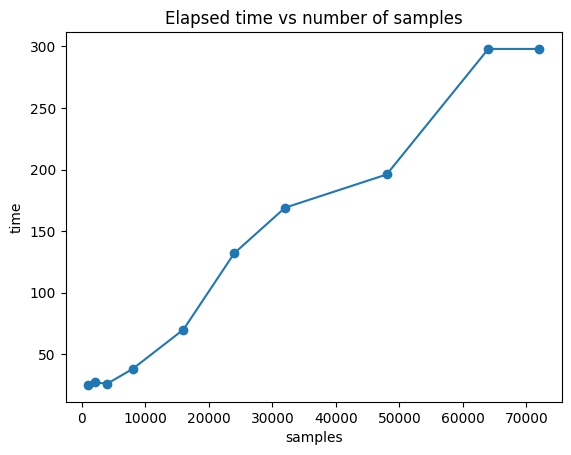

In [29]:
samples_list = [1000, 2000, 4000, 8000, 16000, 24000, 32000, 48000, 64000, 72000] # , 96000]
time_list = [25, 27, 26, 38, 70, 132, 169, 196, 298, 298] # , 461]
plt.plot(samples_list, time_list, 'o-')
plt.title('Elapsed time vs number of samples')
plt.xlabel('samples')
plt.ylabel('time')
plt.show()

In [ ]:
# plt.plot(samples_list, max_eig_list)
# plt.plot(samples_list, min_eig_list)
# plt.title('Eigenvalues of M vs number of samples')
# plt.xlabel('samples')
# plt.ylabel('eigenvalues')
# plt.legend(['max', 'min'])
# plt.show()

### Conditioning number w.r.t. number of parameters

In [14]:
# Set the training parameters to achieve an initial error of around 0.005
# m = 10 (baseline): batch_size = 5000, epochs = 10000, gamma = 0.1, scheduler = exponential_decay(init_value=0.1, transition_steps=1000, decay_rate=0.9)
# m = 15: batch_size = 5000, epochs = 10000, gamma = 0.1, scheduler = exponential_decay(init_value=0.1, transition_steps=1000, decay_rate=0.9)
# m = 20: batch_size = 1000, epochs = 10000, gamma = 0.1, scheduler = exponential_decay(init_value=0.1, transition_steps=1000, decay_rate=0.9)
# m = 25: batch_size = 1000, epochs = 7000, gamma = 0.1, scheduler = exponential_decay(init_value=0.1, transition_steps=1000, decay_rate=0.9)

In [23]:
neurons = 25

training_data = TrainingData(m=neurons, # number of neurons per layer
                             l=1, # number of layers
                             batch_size=500, # batch size
                             epochs=5000, # number of epochs
                             gamma=0.1, # learning rate
                             seed=0, # seed for reproducibility
                             scheduler=optax.exponential_decay(init_value=0.1, transition_steps=1000, decay_rate=0.9) # learning rate scheduler
                            )

net = ShallowNetKdV(training_data.m, problem_data.domain[1] - problem_data.domain[0])

initial_fit = False # True to train a NN to fit the initial condition, False otherwise

if initial_fit:
    theta = init_neural_galerkin(net, problem_data, training_data) # train a NN to fit the initial condition
    jnp.save('./data/theta_init_' + problem_data.name + '_' + str(training_data.seed) + '_' + str(neurons) + '.npy', theta)

In [ ]:
neurons_list = [10, 15, 20, 25]
time_list = []
cond_list = []
# max_eig_list = []
# min_eig_list = []

for neurons in neurons_list:

    print(f'Running model with {neurons} neurons...')

    if neurons == 10:
        theta = jnp.load('./data/theta_init_' + problem_data.name + '_' + str(training_data.seed) + '.npy', allow_pickle=True).item() # baseline
    else:
        theta = jnp.load('./data/theta_init_' + problem_data.name + '_' + str(training_data.seed) + '_' + str(neurons) + '.npy', allow_pickle=True).item()

    net = ShallowNetKdV(neurons, problem_data.domain[1] - problem_data.domain[0])

    time_sum, cond_sum = 0.0, 0.0
    cond_nan = 0
    
    for i in range(5):
        start = time.time()
        solution, timesteps, diagnostic = neural_galerkin(theta=theta, # initial parameters
                                                          net=net, # neural network
                                                          problem_data=problem_data, # problem data
                                                          n=1000, # sample points
                                                          rhs=rhs_kdv, # problem RHS
                                                          x_init=None,
                                                          sampler='uniform',
                                                          scheme='rk45',
                                                          diagnostic_on=True, # save conditioning number and singular values of the mass matrix
                                                          plot_on=False,
                                                          seed=1000*i
                                                         )
        end = time.time()
        time_sum += end - start
        cond = diagnostic.averaged()[0]
        if jnp.isnan(cond):
            cond_nan += 1
        else:
            cond_sum += cond

    print(f'{cond_nan} NaN condition numbers detected.')
    time_list.append(time_sum / 5.0)
    cond_list.append(cond_sum / (5.0 - cond_nan))
    # avg_cond, avg_max_eig, avg_min_eig = diagnostic.averaged()
    # cond_list.append(avg_cond)
    # max_eig_list.append(avg_max_eig)
    # min_eig_list.append(avg_min_eig)

In [ ]:
# 1 inf condition numbers detected with m = 15

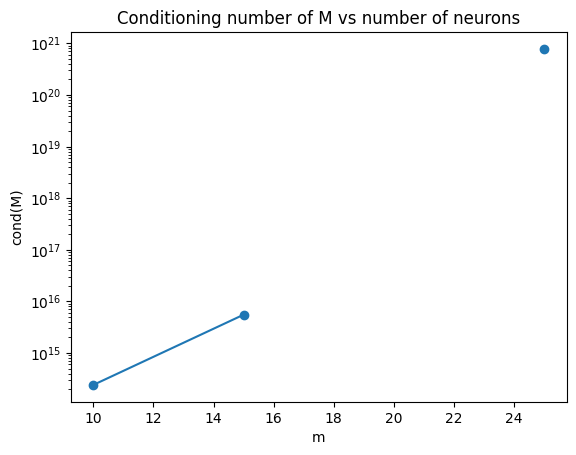

In [34]:
neurons_list = [10, 15, 20, 25]
cond_list = [2.4063502e+14, 5.525942e+15, jnp.inf, 7.8124766e+20]
plt.semilogy(neurons_list, cond_list, 'o-')
plt.title('Conditioning number of M vs number of neurons')
plt.xlabel('m')
plt.ylabel('cond(M)')
plt.show()

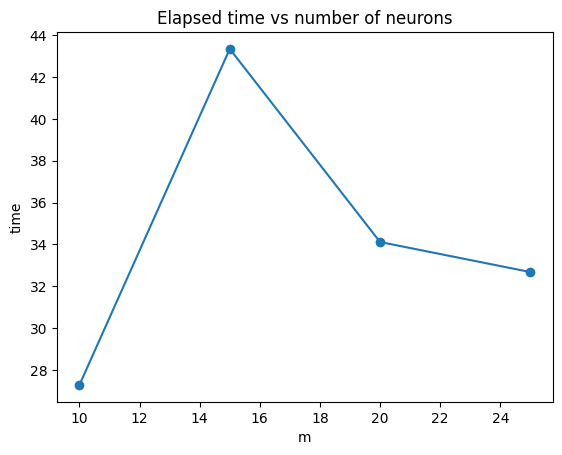

In [35]:
neurons_list = [10, 15, 20, 25]
time_list = [27.283, 43.340, 34.113, 32.677]
plt.plot(neurons_list, time_list, 'o-')
plt.title('Elapsed time vs number of neurons')
plt.xlabel('m')
plt.ylabel('time')
plt.show()

In [ ]:
# plt.plot(neurons_list, max_eig_list)
# plt.plot(neurons_list, min_eig_list)
# plt.title('Eigenvalues of M vs number of neurons')
# plt.xlabel('m')
# plt.ylabel('eigenvalues')
# plt.legend(['max', 'min'])
# plt.show()

### Comparison with Neural Galerkin with adaptive measure

In [8]:
# Accept-reject to sample from the initial condition

from scipy.stats import norm, uniform
from numpy import random

def init_samples_kdv(n, max_it=1000, seed=0):

    random.seed(seed) # set seed for reproducibility

    def KdVWrapper(x):
        x = jnp.array([x])
        kdv = exactKdVTwoSol(x, 0)
        return kdv.squeeze()

    g = norm(loc=-5, scale=4.5) # proposal distribution
    C = 29 # scaling constant

    x = []

    for _ in range(n):
        it = 0
        while it < max_it:
            y = g.rvs() # sample from the Gaussian
            u = uniform.rvs() # sample from a uniform in [0, 1]
            if u <= KdVWrapper(y) / (C * g.pdf(y)):
                x.append(y)
                break
            it += 1
        if it >= max_it:
            raise Exception("AR did not converge.")

    return jnp.array(x)

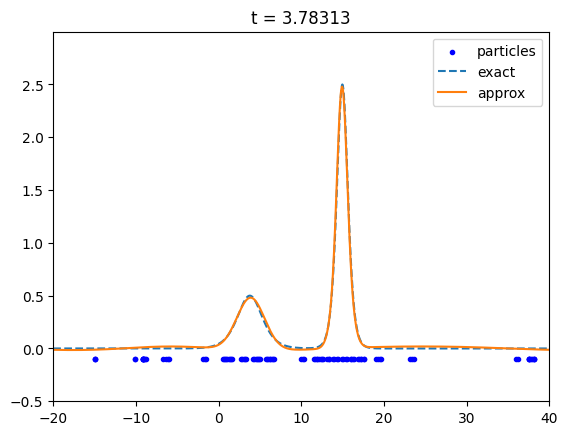

Elapsed time: 1071.618 s


In [11]:
# ORIGINAL SVGD

solution_adaptive, timesteps_adaptive, diagnostic_adaptive = neural_galerkin(theta=theta, # initial parameters
                                                                             net=net, # neural network
                                                                             problem_data=problem_data, # problem data
                                                                             n=100, # sample points
                                                                             rhs=rhs_kdv, # problem RHS
                                                                             x_init=init_samples_kdv(100).reshape(-1, 1), # particles
                                                                             sampler='svgd',
                                                                             scheme='rk45',
                                                                             diagnostic_on=True, # save conditioning number and singular values of the mass matrix
                                                                            )

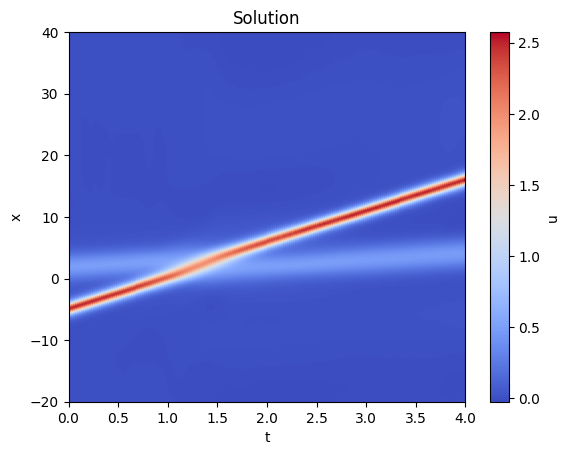

In [12]:
plot_solution(solution_adaptive, timesteps_adaptive, problem_data)

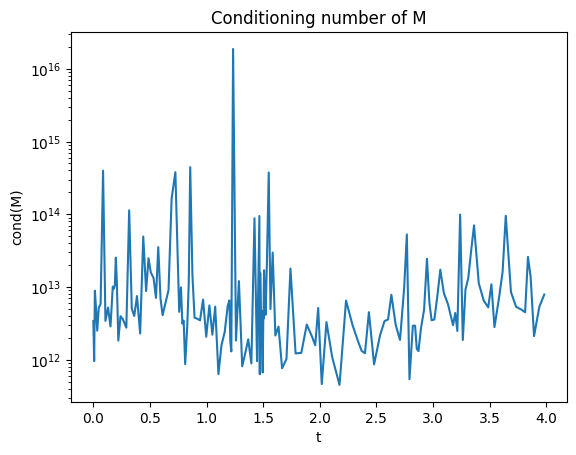

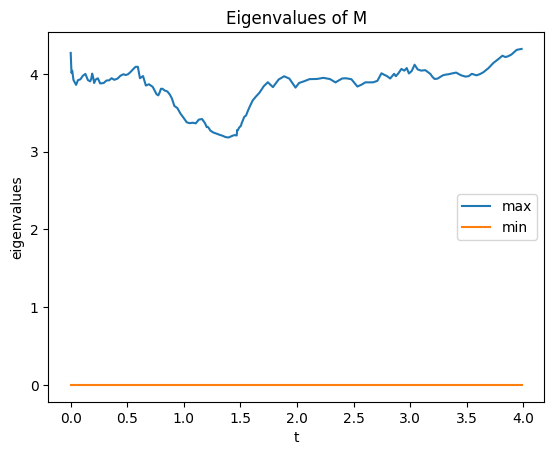

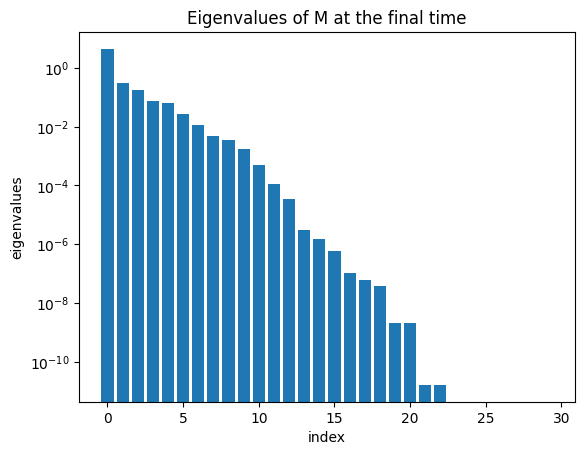

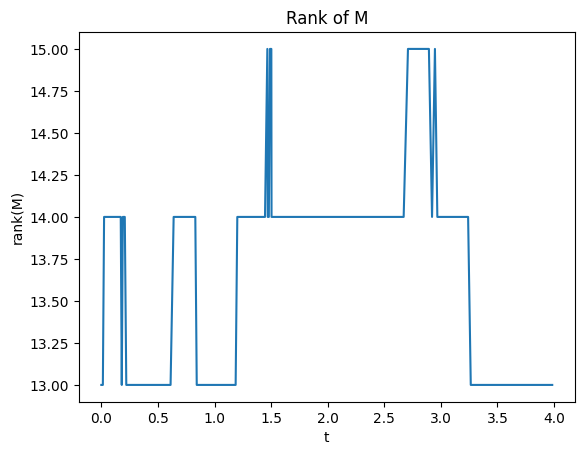

In [13]:
diagnostic_adaptive.plot(timesteps_adaptive)